In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2025-04-18 12:47:23.368687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744955243.386479   34857 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744955243.391830   34857 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744955243.406203   34857 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744955243.406231   34857 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744955243.406233   34857 computation_placer.cc:177] computation placer alr

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 7

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

I0000 00:00:1744955248.687517   34857 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2611 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,147 (4.48 KB)

 Trainable params: 1,147 (4.48 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


I0000 00:00:1744955250.436075   34941 service.cc:152] XLA service 0x7bc580003540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744955250.436098   34941 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-04-18 12:47:30.471206: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744955250.651612   34941 cuda_dnn.cc:529] Loaded cuDNN version 90300


50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1773 - loss: 1.9379

I0000 00:00:1744955252.194891   34941 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1789 - loss: 1.9357
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1797 - loss: 1.9346 - val_accuracy: 0.4133 - val_loss: 1.7420
Epoch 2/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3723 - loss: 1.7019
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3731 - loss: 1.7006 - val_accuracy: 0.5286 - val_loss: 1.4019
Epoch 3/1000
26/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4935 - loss: 1.4443 
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4905 - loss: 1.4309 - val_accuracy: 0.6230 - val_loss: 1.1534
Epoch 4/1000
29/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5519 - loss: 1.2641 
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9382 - loss: 0.2378 


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
[2.6675340e-02 1.4490572e-01 8.2818639e-01 2.2731087e-04 3.8110066e-09
 5.1926777e-06 3.2639856e-18]
2


# Confusion matrix

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


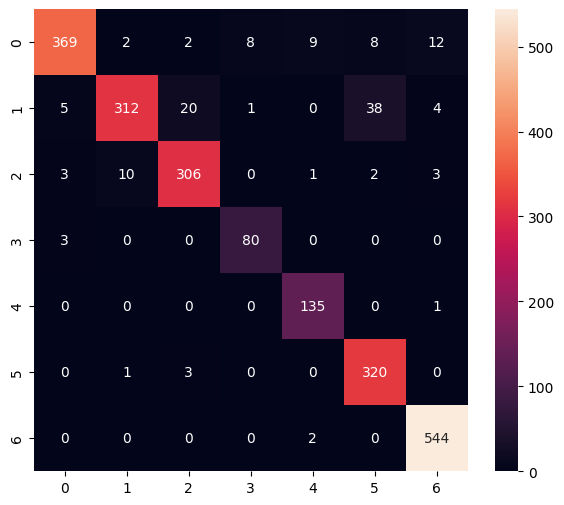

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       410
           1       0.96      0.82      0.89       380
           2       0.92      0.94      0.93       325
           3       0.90      0.96      0.93        83
           4       0.92      0.99      0.95       136
           5       0.87      0.99      0.92       324
           6       0.96      1.00      0.98       546

    accuracy                           0.94      2204
   macro avg       0.93      0.94      0.93      2204
weighted avg       0.94      0.94      0.94      2204



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpa5lt47vc/assets


INFO:tensorflow:Assets written to: /tmp/tmpa5lt47vc/assets


Saved artifact at '/tmp/tmpa5lt47vc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136091977813840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136091977815376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136091977815184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136091977824976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136091977815952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136091977824208: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1744955306.135611   34857 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744955306.135636   34857 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-18 12:48:26.135965: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpa5lt47vc
2025-04-18 12:48:26.136551: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-18 12:48:26.136560: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpa5lt47vc
I0000 00:00:1744955306.140748   34857 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-18 12:48:26.141440: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-18 12:48:26.161567: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpa5lt47vc
2025-04-18 12:48:26.167857: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

6688

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

/mnt/01DB783D25219E60/HOMEWORK/TGMT/ThiGiacPC/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 0 ns, sys: 420 μs, total: 420 μs
Wall time: 305 μs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.6675289e-02 1.4490569e-01 8.2818645e-01 2.2731151e-04 3.8109991e-09
 5.1926681e-06 3.2639732e-18]
2
